<a href="https://colab.research.google.com/github/olavmoeller/OSU-Pitching-Graphics/blob/main/Practice%20Comparison/pitcher_practice_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

I want to make a quick and simple visualization that can show results of a training/bullpen session and compare it to previous sessions/data, in a similar format to the rest of my graphics.

# Notebook Setup

## Installing packages

In [14]:
%cd /content/drive/MyDrive/colab/

!pip install pyfonts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pyfonts import load_font
import pandas as pd
import numpy as np
import api_scraper
from api_scraper import MLB_Scrape

/content/drive/MyDrive/colab


## Plot setup

In [15]:
stratum = load_font(font_url="https://github.com/ccheney/chromotion/blob/master/assets/fonts/stratum2-medium-webfont.ttf?raw=true")

plt.rcParams['figure.dpi'] = 300

### PITCH COLORS ###
pitch_colors = {
    ## Fastballs ##
    'FF': {'color': '#FF007D', 'name': '4-Seam Fastball'},
    'FA': {'color': '#FF007D', 'name': 'Fastball'},
    'SI': {'color': '#98165D', 'name': 'Sinker'},
    'FC': {'color': '#BE5FA0', 'name': 'Cutter'},

    ## Offspeed ##
    'CH': {'color': '#F79E70', 'name': 'Changeup'},
    'FS': {'color': '#FE6100', 'name': 'Splitter'},
    'SC': {'color': '#F08223', 'name': 'Screwball'},
    'FO': {'color': '#FFB000', 'name': 'Forkball'},

    ## Sliders ##
    'SL': {'color': '#67E18D', 'name': 'Slider'},
    'ST': {'color': '#1BB999', 'name': 'Sweeper'},
    'SV': {'color': '#376748', 'name': 'Slurve'},

    ## Curveballs ##
    'KC': {'color': '#311D8B', 'name': 'Knuckle Curve'},
    'CU': {'color': '#3025CE', 'name': 'Curveball'},
    'CS': {'color': '#274BFC', 'name': 'Slow Curve'},
    'EP': {'color': '#648FFF', 'name': 'Eephus'},

    ## Others ##
    'KN': {'color': '#867A08', 'name': 'Knuckleball'},
    'PO': {'color': '#472C30', 'name': 'Pitch Out'},
    'UN': {'color': '#9C8975', 'name': 'Unknown'},
}

# Create a dictionary mapping pitch types to their colors
dict_color = dict(zip(pitch_colors.keys(), [pitch_colors[key]['color'] for key in pitch_colors]))

# Create a dictionary mapping pitch types to their names
dict_pitch = dict(zip(pitch_colors.keys(), [pitch_colors[key]['name'] for key in pitch_colors]))


# Creating the graphic

I will build off of the original summary graphic to make 2 graphics, one about release data and one about pitch movement, as there is too much info for just one graphic. Additionally, these can be used separately depending on the goal of the session, which could include changing of mechanics or working on new pitch shapes.

## Data Processing

While I don't have experience with trackman data yet, I will be able to update this code once I have seen the way it works. For now, as an example, I will split Eric Segura's outing into 2 equal parts, acting as if the first half was one bullpen, and the second half was the next. I will use the metrics shown by trackman on their website as the ones of interest, and calculate them if it isn't done by statcast.

In [16]:
# Activating the scraper
scraper = MLB_Scrape()

# Creating a function that will turn statcast data into trackman data
def statcast_to_trackman(pitchername, gamelist):

    # Calling the relevant game(s) and making a dataframe
    game_data = scraper.get_data(game_list_input = gamelist)
    data_df = scraper.get_data_df(data_list=game_data)
    pd_df = data_df.to_pandas()

    # Filtering by pitcher of interest
    pitcher_df_raw = pd_df[pd_df['pitcher_name'] == pitchername].reset_index(drop=True)

    # Listing the columns we need to keep for trackman calculations
    columns_to_keep = ['pitcher_name', 'pitcher_hand', 'pitch_type', 'start_speed', 'spin_rate', 'spin_direction', 'z0', 'x0', 'y0', 'extension', 'vx0', 'vy0', 'vz0', 'ivb', 'hb', 'pz', 'px', 'ax', 'ay', 'az']

    # Listing the columns that would appear in a trackman dataframe
    trackman_columns = ['pitcher_name', 'pitcher_hand', 'pitch_type', 'release_speed', 'spin_rate', 'spin_axis', 'release_height', 'release_side', 'extension', 'VRA', 'HRA', 'ivb', 'hb', 'pz', 'px', 'VAA', 'HAA']

    # Minimizing our dataset to just what I need to simulate trackman
    trackman_raw = pitcher_df_raw[columns_to_keep]

    # Creating a function that calculates metrics recorded by trackman
    def polishing(df: pd.DataFrame):
        new_df = df.copy()
        new_df['release_speed'] = new_df['start_speed']
        new_df['spin_axis'] = new_df['spin_direction']
        new_df['release_height'] = new_df['z0']
        new_df['release_side'] = new_df['x0']
        new_df['VRA'] = np.arctan(new_df['vz0']/new_df['vy0']) * (180 / np.pi)
        new_df['HRA'] = np.arctan(new_df['vx0']/new_df['vy0']) * (180 / np.pi)
        new_df['vyf'] = -np.sqrt(np.square(new_df['vy0'])-(2*new_df['ay']*(50-17/12)))
        new_df['t'] = (new_df['vyf']-new_df['vy0'])/new_df['ay']
        new_df['vzf'] = new_df['vz0']+new_df['az']*new_df['t']
        new_df['vxf'] = new_df['vx0']+new_df['ax']*new_df['t']
        new_df['VAA'] = -np.arctan(new_df['vzf']/new_df['vyf']) * (180 / np.pi)
        new_df['HAA'] = -np.arctan(new_df['vxf']/new_df['vyf']) * (180 / np.pi)
        return new_df[trackman_columns]

    # Finding our polished result
    tm_polished = polishing(trackman_raw)

    return tm_polished

tm_data = statcast_to_trackman('Eric Segura', [763701])

# Splitting it in half
df_1 = tm_data.iloc[:len(tm_data)//2]
df_2 = tm_data.iloc[len(tm_data)//2:]

tm_data

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 1/1 [00:00<00:00,  3.39iteration/s]

Converting Data to Dataframe.


,pitcher_name,pitcher_hand,pitch_type,release_speed,spin_rate,spin_axis,release_height,release_side,extension,VRA,HRA,ivb,hb,pz,px,VAA,HAA
0,Eric Segura,R,SI,92.9,2259.0,249.0,4.630344,-2.288366,6.509107,2.226549,-4.126898,9.6,16.7,1.132557,0.017221,-6.180136,1.167058
1,Eric Segura,R,SI,91.9,2376.0,242.0,4.684441,-2.202959,6.164353,1.099539,-3.341703,11.0,14.3,2.197892,-0.390895,-4.930613,0.810207
2,Eric Segura,R,CU,79.7,2308.0,58.0,4.931990,-2.140267,6.432895,-0.899313,-2.966336,-3.8,-14.8,2.259209,1.440362,-7.598454,5.594522
3,Eric Segura,R,SI,93.4,2439.0,246.0,4.702093,-2.219723,6.435499,1.794201,-3.588474,10.6,15.0,1.669121,-0.248651,-5.511665,0.933648
4,Eric Segura,R,SI,93.1,2396.0,242.0,4.772016,-1.990875,6.326392,0.525092,-5.328822,11.4,14.9,2.858602,1.472416,-4.140534,2.705073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Eric Segura,R,SI,91.1,2354.0,242.0,4.972505,-2.075351,6.858052,-0.364249,-3.756862,7.9,14.6,3.470351,0.067638,-4.096635,1.177838
78,Eric Segura,R,CH,84.4,1848.0,255.0,4.688295,-2.215494,6.572075,0.213920,-3.156589,-0.6,13.9,1.705163,-0.531516,-7.077645,0.708425
79,Eric Segura,R,CU,78.4,2112.0,57.0,4.920853,-2.312316,6.493047,-0.531877,-1.597690,-3.1,-17.2,1.945658,0.274242,-7.872146,4.626500
80,Eric Segura,R,CU,77.6,2076.0,64.0,4.924752,-2.242595,6.396191,-1.550443,-0.621797,-0.8,-16.0,2.903025,-0.567752,-6.663408,3.452881


## Charts

While I have the code for some charts already in a different workbook, those need to exist here too, in addition to the new charts I'll create.

### Old Charts

Adding the code for charts I have previously made.

#### Short Form Plot

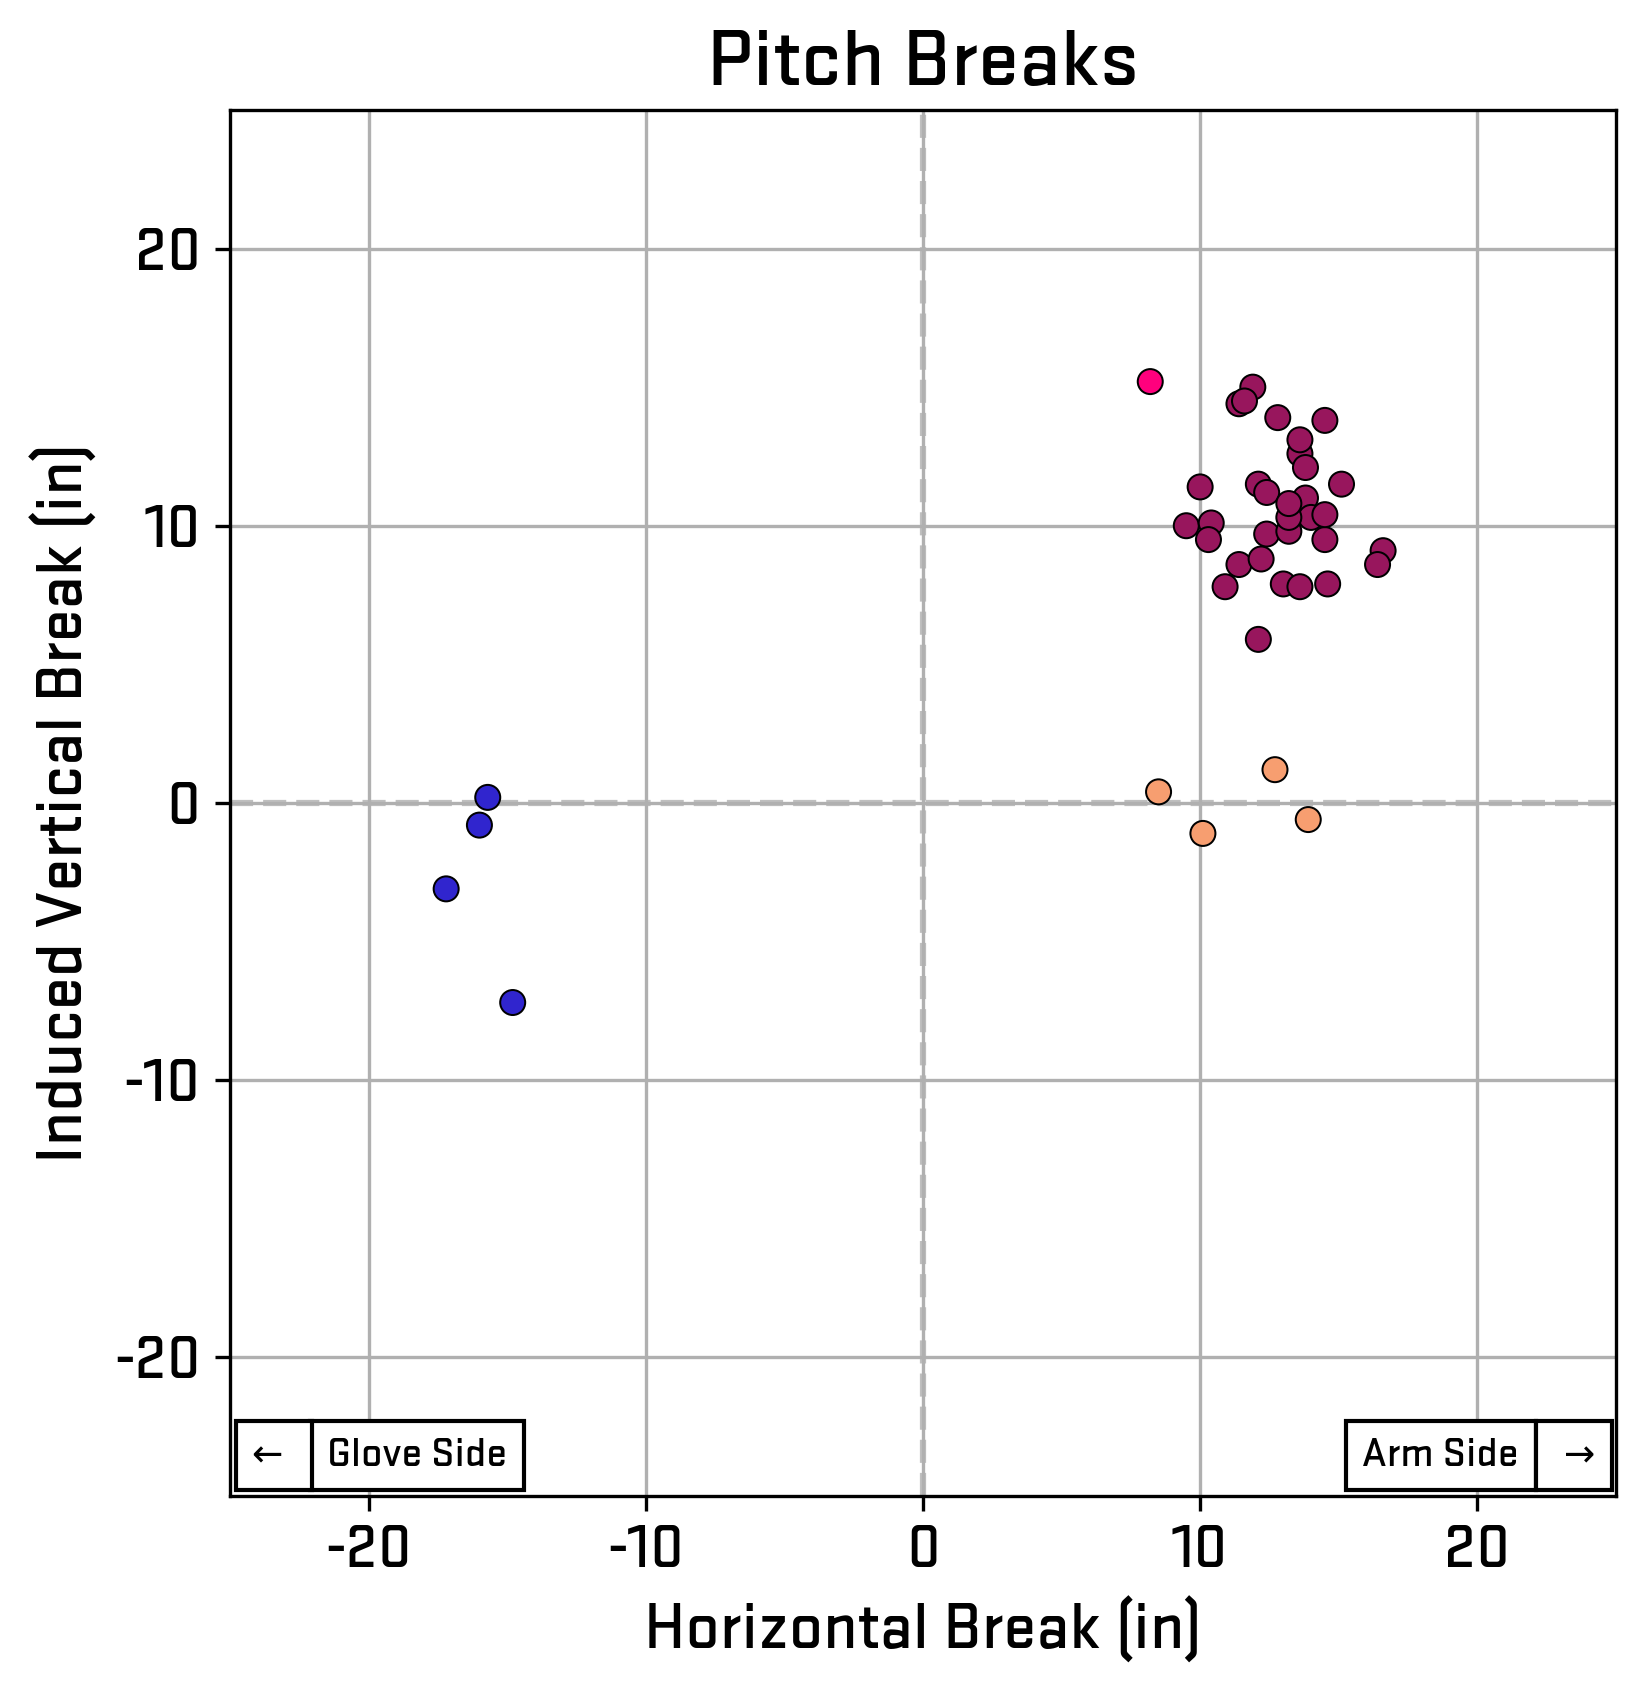

In [17]:
def break_plot(df, ax):

    # Check if the pitcher throws with the right hand
    if df['pitcher_hand'].values[0] == 'R':
        sns.scatterplot(ax=ax,
                        x=df['hb'],
                        y=df['ivb'],
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=2)

    # Check if the pitcher throws with the left hand
    if df['pitcher_hand'].values[0] == 'L':
        sns.scatterplot(ax=ax,
                        x=df['hb']*-1,
                        y=df['ivb'],
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=2)

    # Draw horizontal and vertical lines at y=0 and x=0 respectively
    ax.axhline(y=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)
    ax.axvline(x=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)

    # Set the labels for the x and y axes
    ax.set_xlabel('Horizontal Break (in)', font=stratum, fontsize=16)
    ax.set_ylabel('Induced Vertical Break (in)', font=stratum, fontsize=16)

    # Set the title of the plot
    ax.set_title("Pitch Breaks", font=stratum, fontsize=20)

    # Remove the legend
    ax.get_legend().remove()

    # Set the tick positions and labels for the x and y axes
    ax.set_xticks(range(-20, 21, 10))
    ax.set_xticklabels(range(-20, 21, 10), font=stratum, fontsize=15)
    ax.set_yticks(range(-20, 21, 10))
    ax.set_yticklabels(range(-20, 21, 10), font=stratum, fontsize=15)
    ax.grid()

    # Set the limits for the x and y axes
    ax.set_xlim((-25, 25))
    ax.set_ylim((-25, 25))

    # Add text annotations based on the pitcher's throwing hand
    if df['pitcher_hand'].values[0] == 'R':
        ax.text(-21.5, -24.2, s='Glove Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-24.2, -24.2, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(21.5, -24.2, s='Arm Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(22.7, -24.2, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    if df['pitcher_hand'].values[0] == 'L':
        ax.invert_xaxis()
        ax.text(21.5, -24.2, s='Arm Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(24.2, -24.2, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(-21.5, -24.2, s='Glove Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-22.7, -24.2, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal', adjustable='box')

    # Format the x and y axis tick labels as integers
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

break_plot(df=df_2, ax=plt.subplots(figsize=(6, 6))[1])

#### Velocity Histogram

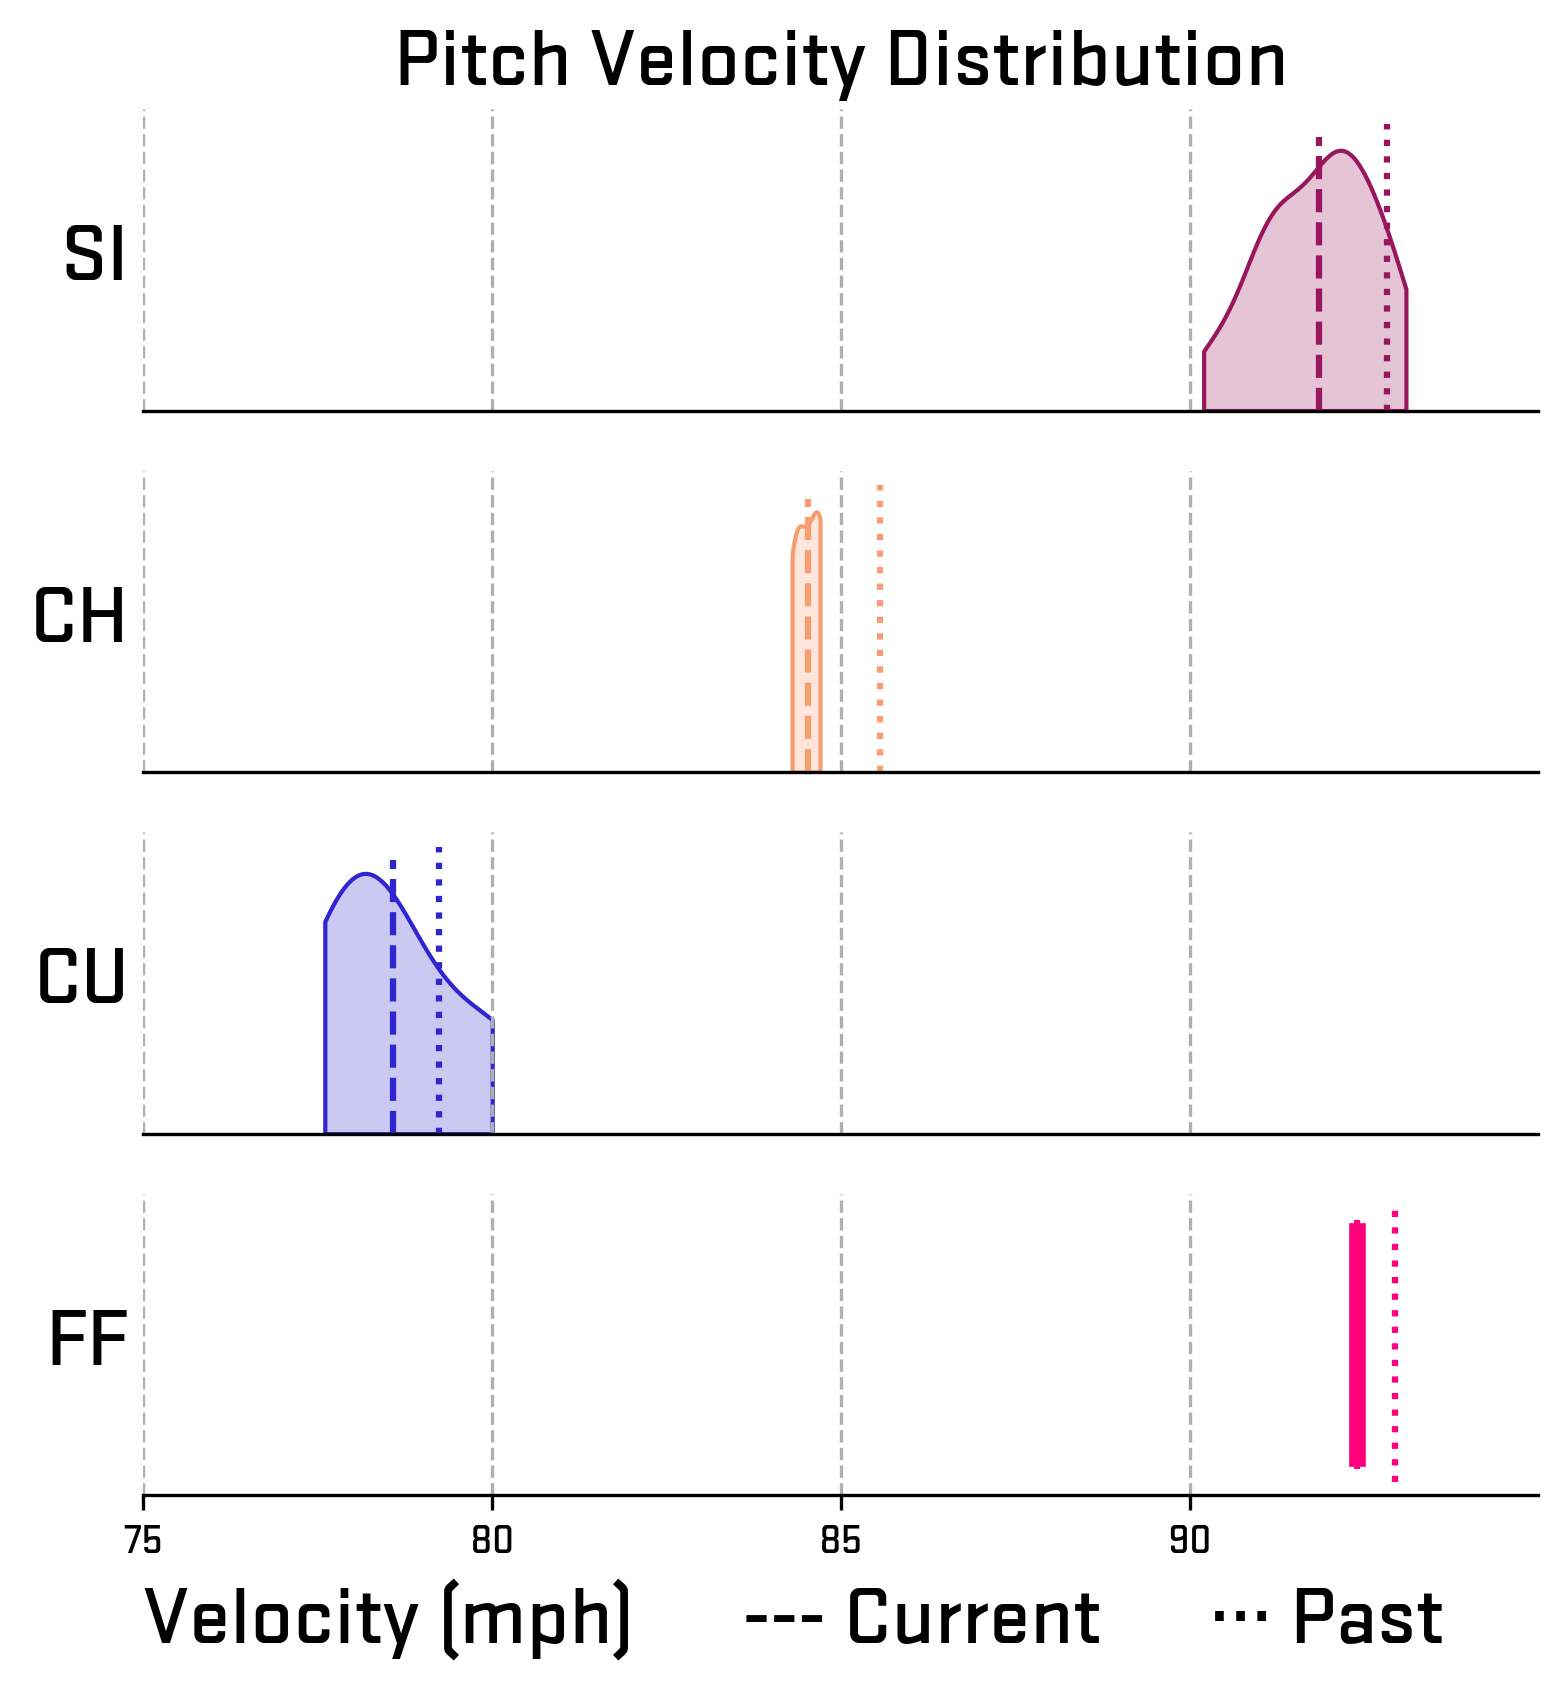

In [34]:
def velocity_chart(df, past_df, fig, ax, gs, gs_x, gs_y):

    # Get the count of each pitch type and sort them in descending order
    sorted_value_counts = df['pitch_type'].value_counts().sort_values(ascending=False)

    # Get the list of pitch types ordered from most to least frequent
    items_in_order = sorted_value_counts.index.tolist()

    # Turn off the axis and set the title for the main plot
    ax.axis('off')
    ax.set_title('Pitch Velocity Distribution', font=stratum, fontsize=20)

    # Create a grid for the inner subplots
    inner_grid_1 = gridspec.GridSpecFromSubplotSpec(len(items_in_order), 1, subplot_spec=gs[gs_x[0]:gs_x[-1], gs_y[0]:gs_y[-1]])
    ax_top = []

    # Create subplots for each pitch type
    for inner in inner_grid_1:
        ax_top.append(fig.add_subplot(inner))
    ax_number = 0
    for i in items_in_order:
        # Check if all release speeds for the pitch type are the same
        if np.unique(df[df['pitch_type'] == i]['release_speed']).size == 1:
            # Plot a single line if all values are the same
            ax_top[ax_number].plot([np.unique(df[df['pitch_type'] == i]['release_speed']),
                              np.unique(df[df['pitch_type'] == i]['release_speed'])], [0, 1], linewidth=4,
                              color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]], zorder=20)
        else:
            # Plot the KDE for the release speeds
            sns.kdeplot(df[df['pitch_type'] == i]['release_speed'], ax=ax_top[ax_number], fill=True,
                  clip=(df[df['pitch_type'] == i]['release_speed'].min(), df[df['pitch_type'] == i]['release_speed'].max()),
                  color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]])

        # Plot the mean release speed for the OSU data
        df_average = df[df['pitch_type'] == i]['release_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                      [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                      color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                      linestyle='--')

        # Plot the mean release speed for the previous/comparison data
        df_average = past_df[past_df['pitch_type'] == i]['release_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                      [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                      color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                      linestyle=':')
        # Define min and max of velo rounded to nearest 5 for limits/ticks
        min_velo = np.floor(df['release_speed'].min() / 5).astype(int) * 5
        max_velo = np.ceil(df['release_speed'].max() / 5).astype(int) *5

        # Set the x-axis limits
        ax_top[ax_number].set_xlim(min_velo, max_velo)
        ax_top[ax_number].set_xlabel('')
        ax_top[ax_number].set_ylabel('')

        # Hide the top, right, and left spines for all but the last subplot
        if ax_number < len(items_in_order) - 1:
            ax_top[ax_number].spines['top'].set_visible(False)
            ax_top[ax_number].spines['right'].set_visible(False)
            ax_top[ax_number].spines['left'].set_visible(False)
            ax_top[ax_number].tick_params(axis='x', colors='none')

        # Set the x-ticks and y-ticks
        ax_top[ax_number].set_xticks(range(min_velo, max_velo, 5))
        ax_top[ax_number].set_yticks([])
        ax_top[ax_number].grid(axis='x', linestyle='--')
        for label in ax_top[ax_number].get_xticklabels():
            label.set_fontproperties(stratum)

        # Add text label for the pitch type
        ax_top[ax_number].text(-0.01, 0.5, i, transform=ax_top[ax_number].transAxes,
                      fontsize=20, va='center', ha='right', font=stratum)
        ax_number += 1

    # Hide the top, right, and left spines for the last subplot
    ax_top[-1].spines['top'].set_visible(False)
    ax_top[-1].spines['right'].set_visible(False)
    ax_top[-1].spines['left'].set_visible(False)

    # Set the x-ticks and x-label for the last subplot
    ax_top[-1].set_xticks(list(range(min_velo, max_velo, 5)))
    ax_top[-1].set_xlabel('Velocity (mph)      --- Current      ··· Past', fontsize=20, font=stratum, loc='left')


fig, ax = plt.subplots(figsize=(6, 6))
velocity_chart(df=df_2, past_df=df_1, fig=fig, ax=ax, gs=gridspec.GridSpec(1, 1), gs_x=[0, 1], gs_y=[0, 1])


### New Charts

I will include a couple of new charts for these graphics, as the pitch plinko isn't relevant for a bullpen session, and there are some new charts I want to showcase, being relevant to the two graphics I will create.

## Making the Raw Table

In [26]:
# Defining a function to group dataframes by pitch type, as we will have multiple dataframes to work with
def tm_grouping(df: pd.DataFrame):
    df_group = df.groupby(['pitcher_name','pitcher_hand','pitch_type']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        release_speed = ('release_speed','mean'),  # Average start speed
                        spin_rate = ('spin_rate','mean'),  # Average spin rate
                        spin_axis = ('spin_axis','mean'),  # Average spin axis
                        release_height = ('release_height','mean'),  # Average vertical release position
                        release_side = ('release_side','mean'),  # Average horizontal release position
                        extension = ('extension','mean'),  # Average release extension
                        VRA = ('VRA','mean'),  # Average vertical release angle
                        HRA = ('HRA','mean'),  # Average horizontal release angle
                        ivb = ('ivb','mean'),  # Average vertical movement
                        hb = ('hb','mean'),  # Average horizontal movement
                        pz = ('pz','mean'),  # Average plate height
                        px = ('px','mean'),  # Average plate side
                        VAA = ('VAA','mean'),  # Average vertical approach angle
                        HAA = ('HAA','mean')  # Average horizontal approach angle
                        ).reset_index()
    return df_group

grp_df_1 = tm_grouping(df_1)
grp_df_2 = tm_grouping(df_2)

grp_df_2

,pitcher_name,pitcher_hand,pitch_type,pitch,release_speed,spin_rate,spin_axis,release_height,release_side,extension,VRA,HRA,ivb,hb,pz,px,VAA,HAA
0,Eric Segura,R,CH,4,84.525000,1844.50000,255.0000,4.556875,-2.092984,6.771949,1.245181,-3.900248,-0.0250,11.30000,0.751956,0.409722,-7.957183,1.911932
1,Eric Segura,R,CU,4,78.575000,2173.25000,59.5000,4.937052,-2.274524,6.471048,-0.963624,-0.845574,-2.7250,-15.92500,2.353776,-0.415137,-7.405348,3.665411
2,Eric Segura,R,FF,1,92.400000,2384.00000,241.0000,4.738906,-1.811920,6.433290,1.697760,-5.265999,15.2000,8.20000,2.083299,2.085076,-4.684272,3.841813
3,Eric Segura,R,SI,32,91.846875,2367.71875,239.8125,4.836746,-2.107003,6.419131,0.820281,-3.312514,10.5875,12.89375,2.558528,-0.220407,-4.716948,1.029156
